In [1]:
import torch
from torchvision import models, transforms
import numpy as np
from PIL import Image

In [ ]:
models.AlexNet()

In [ ]:
models.alexnet()

In [ ]:
%time to =  torch.randn(3,11,11)
#print(t.shape)

CPU times: user 4.65 ms, sys: 39 µs, total: 4.69 ms
Wall time: 5.02 ms


In [ ]:
%time nu = np.random.randn(3,11,11)

CPU times: user 56 µs, sys: 3 µs, total: 59 µs
Wall time: 62.2 µs


In [ ]:
model = models.AlexNet()

In [ ]:
model(t)

RuntimeError: ignored

In [ ]:
t.shape

torch.Size([3, 11, 11])

In [ ]:
q = torch.unsqueeze(t, dim=0)
q.shape

torch.Size([1, 3, 11, 11])

In [ ]:
?torch.unsqueeze

In [ ]:
?torch.flatten

In [ ]:
t_flat = torch.flatten(t)
t.shape , t_flat.shape

(torch.Size([64, 3, 11, 11]), torch.Size([23232]))

In [ ]:
t_c_stack = torch.column_stack(t)
t_c_stack.shape

TypeError: ignored

In [ ]:
?torch.randn

In [ ]:
n = torch.randn(2,2)
torch.mean(n)

tensor(0.7981)

In [ ]:
%time
torch.mean(torch.randn(4))


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


tensor(0.3072)

In [ ]:
img = Image.open('bobby.jpg')
img.size

(1280, 720)

In [ ]:
preprocess = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(
         mean = [0.485, 0.456, 0.406],
         std = [0.229, 0.224, 0.225]
     )
    ]
)

In [ ]:
img_t = preprocess(img)

In [ ]:
img_t.shape

torch.Size([3, 224, 224])

In [ ]:
#It adds batch to the image 
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
resnet = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
resnet.eval()


In [ ]:
out = resnet(batch_t)


In [ ]:
out

In [ ]:
torch.argmax(out[0])

tensor(207)

In [ ]:
#Let the label of the output
with open('imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()] 

In [ ]:
labels[torch.argmax(out[0])]

'golden retriever'

In [ ]:
_, index = torch.max(out,1)
index[0]

tensor(207)

In [ ]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
#percentage[0]*100
labels[index[0]], percentage[index[0]].item()

('golden retriever', 90.2922134399414)

In [ ]:
#Let's sort the outputs
_, indices = torch.sort(out,dim=1, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('golden retriever', 90.2922134399414),
 ('Labrador retriever', 5.132657051086426),
 ('redbone', 1.4370511770248413),
 ('cocker spaniel, English cocker spaniel, cocker', 1.0196644067764282),
 ('beagle', 0.622511088848114)]

###Lets try predicting different images

In [ ]:
horse_img = Image.open('horse.jpg')
horse_img

In [ ]:
horse_img.size

(1500, 1220)

In [ ]:
horse_t = preprocess(horse_img)
horse_t.shape

torch.Size([3, 224, 224])

In [ ]:
batch_horse = torch.unsqueeze(horse_t,0)
batch_horse.shape

torch.Size([3, 224, 224])

In [ ]:
horse_out = resnet(batch_horse)

In [ ]:
horse_out

In [ ]:
_, horse_index = torch.max(horse_out, dim=1)
horse_index

tensor([339])

In [ ]:
percntage_horse = torch.nn.functional.softmax(horse_out,dim=1)[0] * 100
percntage_horse

In [ ]:
##Lets c top 5 prediction
_,out_sorted = torch.sort(out[0], descending=True)
[(labels[idx], percntage_horse[idx].item()) for idx in out_sorted[:5]]

[('sorrel', 50.8499755859375),
 ('Arabian camel, dromedary, Camelus dromedarius', 18.580211639404297),
 ('horse cart, horse-cart', 6.446576118469238),
 ('plow, plough', 5.754566669464111),
 ('cowboy boot', 2.987431764602661)]

#Let's build CycleGAN

In [ ]:

import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
netG = ResNetGenerator()

In [ ]:
model_path = "horse2zebra_0.4.0.pth"
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
netG.eval()

In [ ]:
gan_preprocess = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.ToTensor()
])

In [ ]:
gan_img = Image.open("horse.jpg")
gan_img

In [ ]:
gan_img_t = gan_preprocess(gan_img)
batch_gan_img = torch.unsqueeze(gan_img_t, 0)

In [ ]:
batch_gan_out = netG(batch_gan_img)

batch_gan_out is the output of the generator -> lets convert it into an image

In [ ]:
gan_out = (batch_gan_out.squeeze() + 1.0)/2.0
out_gan_img = transforms.ToPILImage()(gan_out)

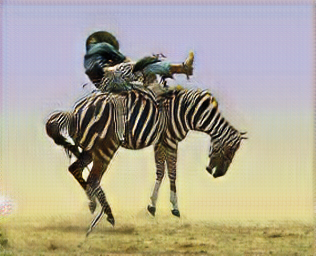

In [ ]:
out_gan_img

# Chapter - 3

In [ ]:
points = torch.tensor([1.0, 2.0, 3.0])
points.storage()

 1.0
 2.0
 3.0
[torch.FloatStorage of size 3]

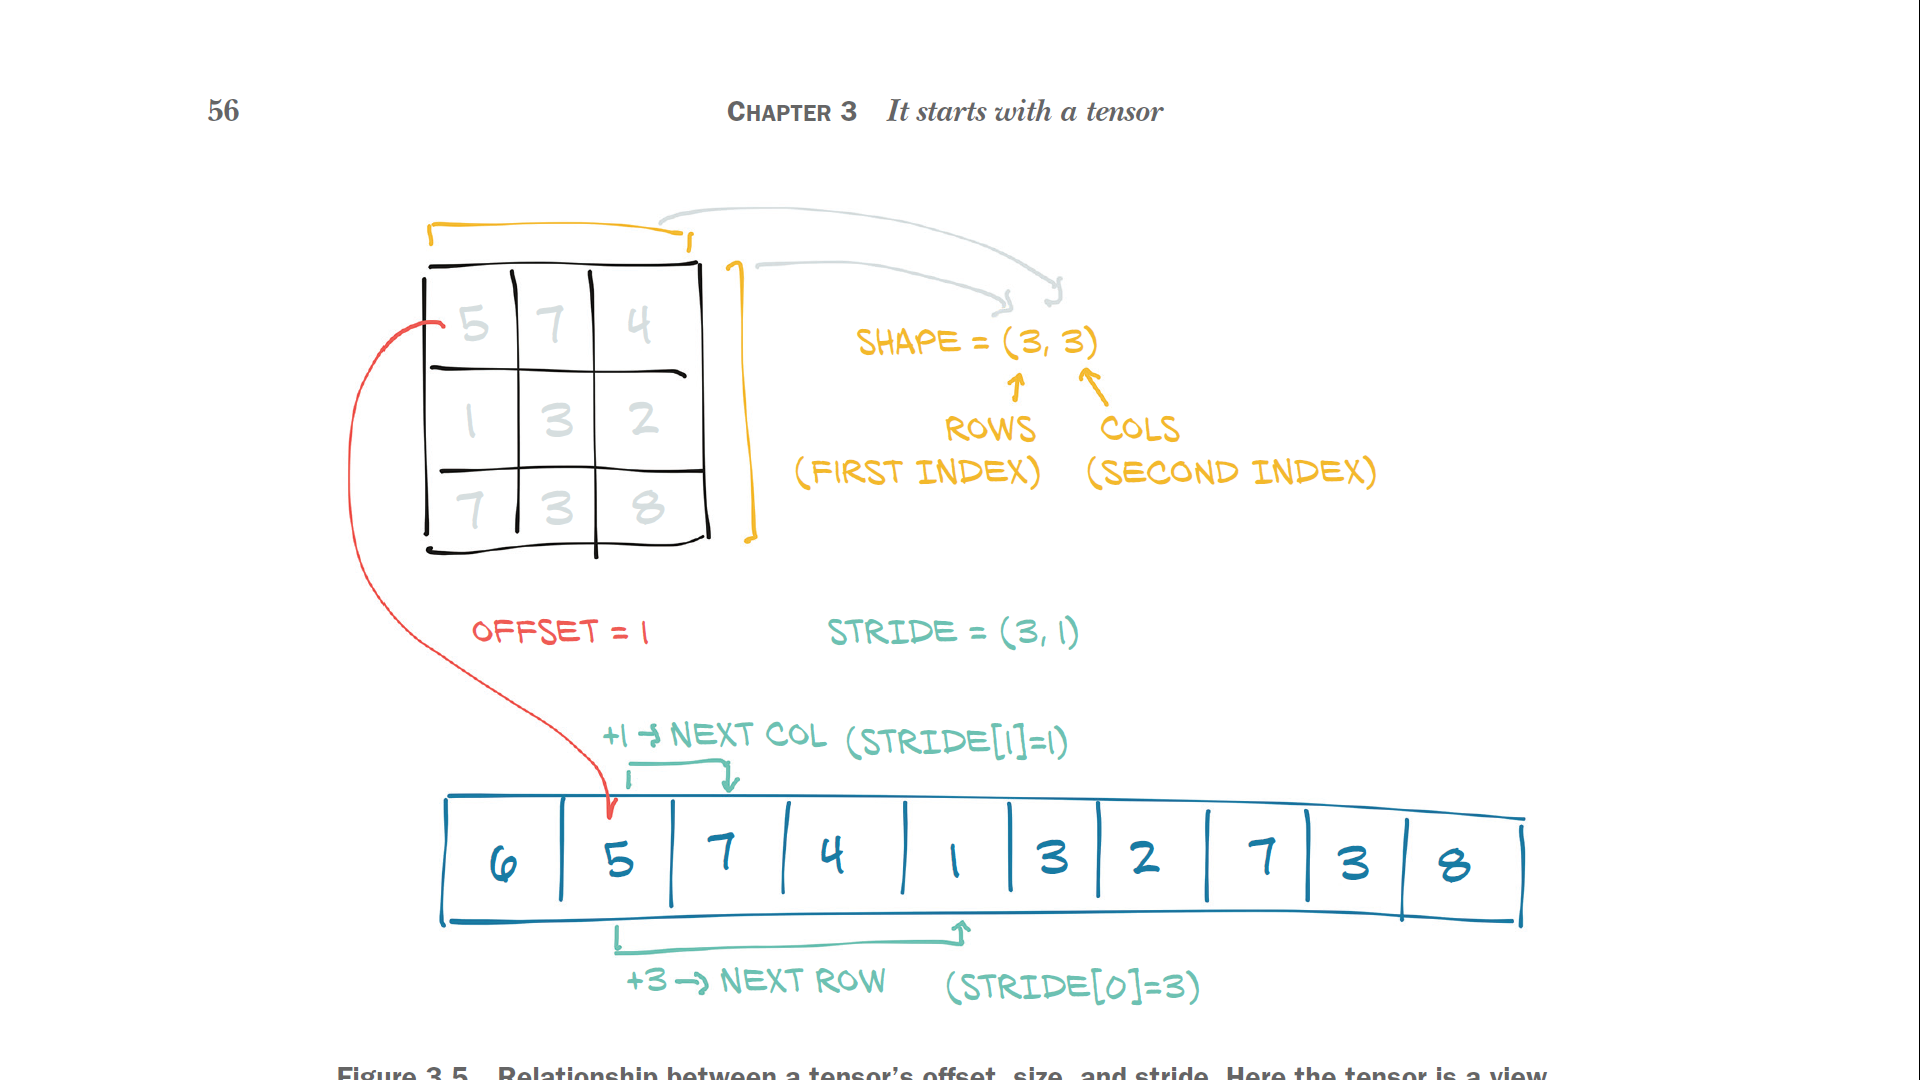

Consider a tensor t = [[1,2,3],[4,5,6],[6,7,8]] -> this is of shape (3,3)
But Pytorch stores it as a single continguous array, therefore it to store it in a order, in which it can retrieve without affecting the order of the values.

It uses Offset and Stride.

Here for tensor of shape (3,3) ,we are taking stride as (3,1).
We have to move by '3' locations to get the next value in the row and by '1' location for next value in the column

In [ ]:
t = torch.tensor([[1,2,3],[4,5,6],[6,7,8]])
t.shape

torch.Size([3, 3])

In [ ]:
t[1][1].storage_offset()

4

In [ ]:
t.stride()

(3, 1)

In [ ]:
a = torch.tensor([1.,2.,3.,0])
a

tensor([1., 2., 3., 0.])

In [ ]:
a.is_sparse

False

#### Saving a tensor

In [ ]:
torch.save(a,"a.t")

In [ ]:
b = torch.load("a.t")
b

tensor([1., 2., 3., 0.])

##### Saving a tensor in hdf5 format for interoperability.


In [ ]:
import h5py

In [ ]:
f = h5py.File('a.hdf5', 'w')
dset = f.create_dataset('coords', data= a.numpy())
f.close()

In [ ]:
f = h5py.File('a.hdf5','r')
dset = f['coords']
points = dset[:]

In [ ]:
points_tensor = torch.from_numpy(points)
points_tensor
f.close()

tensor([])

In [20]:
a = torch.Tensor([1.,2.,3.])
b = a.detach().cpu()
c = a.clone()
c.data_ptr(), b.data_ptr()

(94523517557888, 94523517557952)

In [23]:
??torch.Tensor.data_ptr